In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Kategori Lowongan   3200 non-null   object 
 1   Pekerjaan Lowongan  3200 non-null   object 
 2   Title               3200 non-null   object 
 3   Posisi              3200 non-null   object 
 4   Gaji                3200 non-null   object 
 5   Gaji Min            1142 non-null   float64
 6   Gaji Max            1142 non-null   float64
 7   Kualifikasi         3200 non-null   object 
 8   Tahun Pengalaman    69 non-null     float64
 9   Umur                31 non-null     float64
 10  Pendidikan          126 non-null    object 
 11  Skill               423 non-null    object 
 12  Link                3200 non-null   object 
dtypes: float64(4), object(9)
memory usage: 325.1+ KB


Text(0.5, 0, 'Gaji Max')

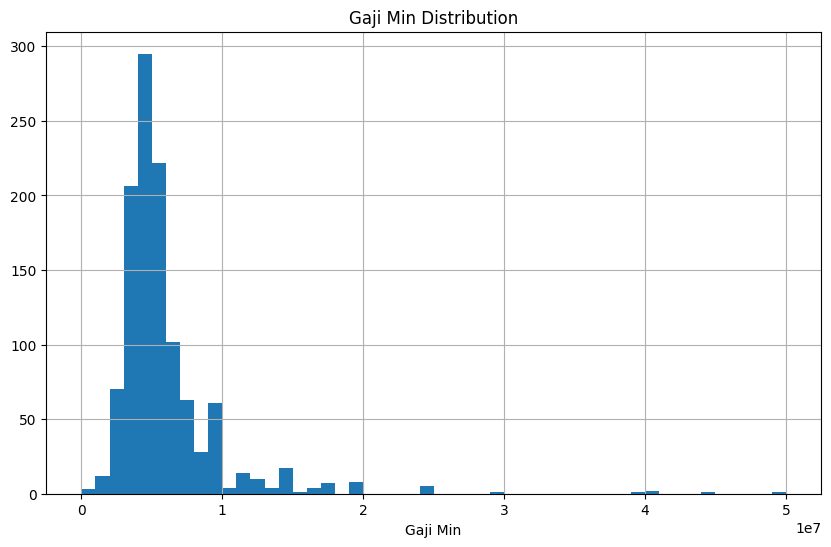

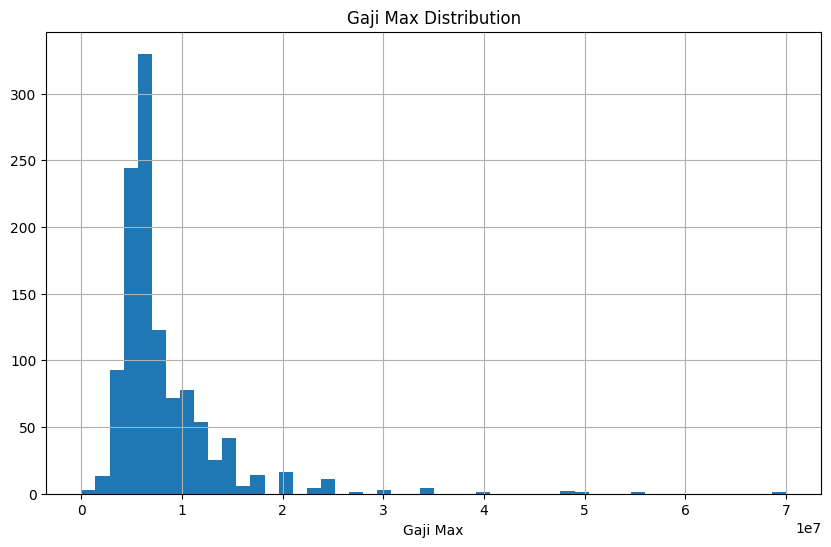

In [11]:
df = pd.read_csv('jobstreet_jobs_cleaned_with_category.csv')

df.describe()
df.info()

plt.figure(figsize=(10, 6))
df['Gaji Min'].hist(bins=50)
plt.title('Gaji Min Distribution')
plt.xlabel('Gaji Min')

plt.figure(figsize=(10, 6))
df['Gaji Max'].hist(bins=50)
plt.title('Gaji Max Distribution')
plt.xlabel('Gaji Max')

In [12]:
df['Gaji_Min'] = pd.to_numeric(df['Gaji Min'], errors='coerce')
df['Gaji_Max'] = pd.to_numeric(df['Gaji Max'], errors='coerce')
df['Gaji_Rata2'] = df[['Gaji_Min', 'Gaji_Max']].mean(axis=1)

# Select relevant features and target
data = df[['Kategori Lowongan', 'Umur', 'Pendidikan', 'Title', 'Link', 'Gaji_Rata2']]

# Drop rows where target is missing
data = data.dropna(subset=['Gaji_Rata2'])

# Impute missing values for 'Umur' with median
imputer_umur = SimpleImputer(strategy='median')
data['Umur'] = imputer_umur.fit_transform(data[['Umur']]).ravel()

imputer_pend = SimpleImputer(strategy='most_frequent')
data['Pendidikan'] = imputer_pend.fit_transform(data[['Pendidikan']]).ravel()

le_kategori = LabelEncoder()
data['Kategori_Encoded'] = le_kategori.fit_transform(data['Kategori Lowongan'])

le_pendidikan = LabelEncoder()
data['Pendidikan_Encoded'] = le_pendidikan.fit_transform(data['Pendidikan'])

X = data[['Kategori_Encoded', 'Umur', 'Pendidikan_Encoded']]
y = data['Gaji_Rata2']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

# Tampilkan hasil
print("Random Forest:    R2 = {:.2f}, RMSE = {:.2f}".format(rf_r2, rf_rmse))
print("Linear Regression: R2 = {:.2f}, RMSE = {:.2f}".format(lr_r2, lr_rmse))
print("XGBoost:          R2 = {:.2f}, RMSE = {:.2f}".format(xgb_r2, xgb_rmse))

model_scores = {
    rf: rf_r2,
    lr: lr_r2,
    xgb_model: xgb_r2
}

best_model = max(model_scores, key=model_scores.get)

print(f"Model terbaik: {type(best_model).__name__}")

joblib.dump(best_model, 'gaji_prediksi_model.joblib')



Random Forest:    R2 = -0.01, RMSE = 3942942.30
Linear Regression: R2 = -0.01, RMSE = 3927900.90
XGBoost:          R2 = -0.04, RMSE = 3998216.35
Model terbaik: LinearRegression


['gaji_prediksi_model.joblib']

In [15]:
joblib.dump(le_kategori, 'label_encoder_kategori.joblib')
joblib.dump(le_pendidikan, 'label_encoder_pendidikan.joblib')
joblib.dump(imputer_umur, 'imputer_umur.joblib')
joblib.dump(imputer_pend, 'imputer_pendidikan.joblib')

['imputer_pendidikan.joblib']

In [16]:
data.to_csv('job_data_for_streamlit.csv', index=False)